In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd 'drive/MyDrive/Colab Notebooks/Project/'

/content/drive/MyDrive/Colab Notebooks/Project


In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from importlib import reload
from PIL import Image

from HandDataset_noCoords import *
from Networks import *

manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)

In [2]:
synth_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])

real_transform = transforms.Compose([
    transforms.CenterCrop(112),
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])


real_train = HandDataset(
    img_dir='C:/Users/lucas/OneDrive - University of Glasgow/Glasgow/FreiHAND_split/training/rgb',
    mask_dir='C:/Users/lucas/OneDrive - University of Glasgow/Glasgow/FreiHAND_split/training/mask',
    anno_path='C:/Users/lucas/OneDrive - University of Glasgow/Glasgow/FreiHAND_split/FreiHAND_anno_training.pickle', # incomplete (only contains xyz data)
    zfill=8,
    ext='.jpg',
    black_size=224,
    masked=True,
    transform=real_transform,
    normalise=False
)

real_test = HandDataset(
    img_dir='C:/Users/lucas/OneDrive - University of Glasgow/Glasgow/FreiHAND_split/evaluation/rgb',
    mask_dir='C:/Users/lucas/OneDrive - University of Glasgow/Glasgow/FreiHAND_split/evaluation/mask',
    anno_path='C:/Users/lucas/OneDrive - University of Glasgow/Glasgow/FreiHAND_split/FreiHAND_anno_training.pickle', # incomplete (only contains xyz data)
    zfill=8,
    ext='.jpg',
    black_size=224,
    masked=True,
    transform=real_transform,
    normalise=False
)

synth_train = HandDataset(
    img_dir='C:/Users/lucas/Downloads/RHD_v1-1/RHD_published_v2/training/color/',
    mask_dir='C:/Users/lucas/Downloads/RHD_v1-1/RHD_published_v2/training/mask/',
    anno_path='C:/Users/lucas/Downloads/RHD_v1-1/RHD_published_v2/training/anno_training.pickle',
    black_size=320,
    zfill=5,
    ext='.png',
    transform=synth_transform,
    masked=True,
    centered=True,
    coef = 2.2,
    normalise=True
)

synth_test = HandDataset(
    img_dir='C:/Users/lucas/Downloads/RHD_v1-1/RHD_published_v2/evaluation/color/',
    mask_dir='C:/Users/lucas/Downloads/RHD_v1-1/RHD_published_v2/evaluation/mask/',
    anno_path='C:/Users/lucas/Downloads/RHD_v1-1/RHD_published_v2/evaluation/anno_evaluation.pickle',
    black_size=320,
    zfill=5,
    ext='.png',
    transform=synth_transform,
    masked=True,
    centered=True,
    coef = 2.2,
    normalise=True
)

In [6]:
synth_test_loader = DataLoader(synth_test, batch_size=64, shuffle=False, drop_last=True)
real_test_loader = DataLoader(real_train, batch_size=64, shuffle=False, drop_last=True)

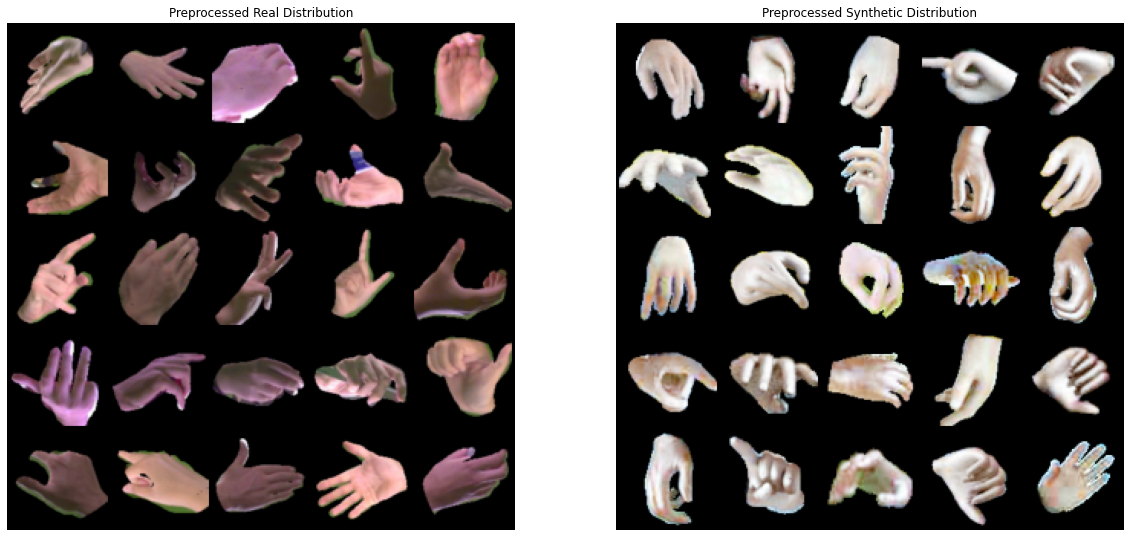

In [7]:
fixed_real = next(iter(real_test_loader))[0][:25]
fixed_synth = next(iter(synth_test_loader))[0][:25]

plt.figure(figsize=(20,40))
ax = plt.subplot(2,2,1)
plt.axis('off')
plt.title('Preprocessed Real Distribution')
plt.imshow(np.transpose(vutils.make_grid(fixed_real[:64],
                                        padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

ax = plt.subplot(2,2,2)
plt.axis('off')
plt.title('Preprocessed Synthetic Distribution')
plt.imshow(np.transpose(vutils.make_grid(fixed_synth[:64],
                                        padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

In [45]:
Enc = Encoder(128,64)
Dec = Decoder(128,64)
Enc.load_state_dict(torch.load('models/vaegan/enc_checkpoint_epoch_5.pth', map_location=torch.device('cpu')))
Dec.load_state_dict(torch.load('models/vaegan/dec_checkpoint_epoch_5.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [54]:
mu,logvar = Enc(fixed_synth)
z = reparameterize(mu,logvar)
out = Dec(z)

In [13]:
G_s2r = CycleGenerator(num_residuals=4)
G_s2r.load_state_dict(torch.load('models/cyclegan_auth/G_s2r_27_11_21_epoch_30.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
out1 = G_s2r(fixed_synth)

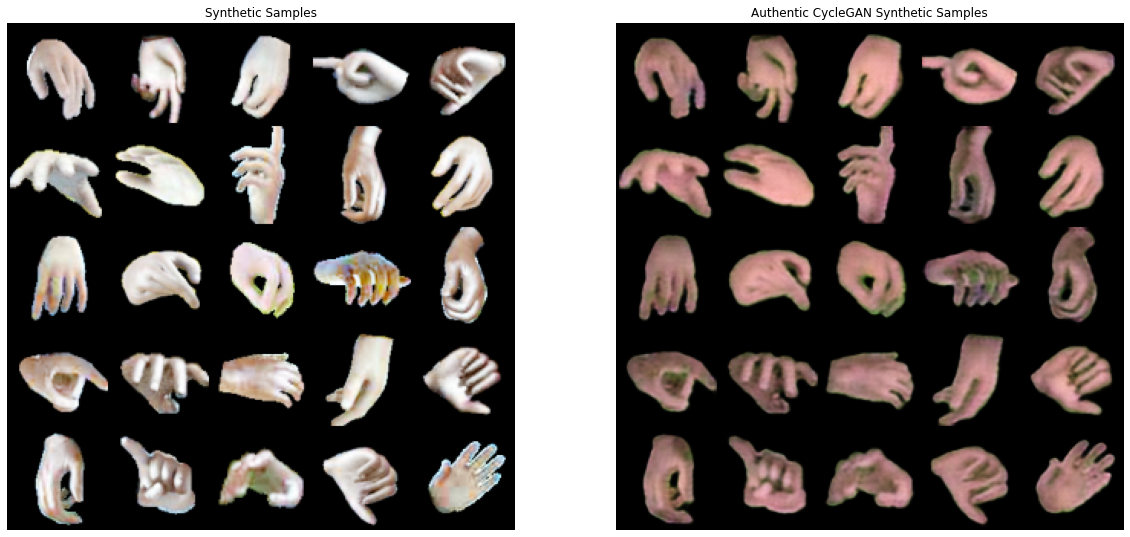

In [16]:
plt.figure(figsize=(20,40))
ax = plt.subplot(2,2,1)
plt.axis('off')
plt.title('Synthetic Samples')
plt.imshow(np.transpose(vutils.make_grid(fixed_synth[:25],
                                        padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

ax = plt.subplot(2,2,2)
plt.axis('off')
plt.title('Authentic CycleGAN Synthetic Samples')
plt.imshow(np.transpose(vutils.make_grid(out1[:25],
                                        padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

In [33]:
versions = {'rhd_raw':[], 'rhd':[], 'vaegan':[], 'cyclegan_auth':[], 'cyclegan_disc':[], 'freihand':[], 'freihand_SAME_samples':[]}

In [35]:
for v in versions:
    for i in range(5):
        path = f'scores/{v}/{i}.npy'
        try:
            versions[v].append(np.load(path))
        except:
            pass

In [36]:
scores = {'rhd_raw':[], 'rhd':[], 'vaegan':[], 'cyclegan_auth':[], 'cyclegan_disc':[], 'freihand':[], 'freihand_SAME_samples':[]}

In [37]:
for v in versions:
    scores[v].append( np.mean(np.array(versions[v]), axis=0) )
    scores[v].append( np.std(np.array(versions[v]), axis=0) )

C:\Users\lucas\anaconda3\envs\DataScience\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lucas\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lucas\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\lucas\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\lucas\anaconda3\envs\DataScience\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
keys = {
    0:'wasserstein(Mxy) f1',
    1:'mmd(Mxx,Mxy,Myy,1) f1',
    2:'knn accuracy f1',
    3:'knn real accuracy f1',
    4:'knn fake accuracy f1',
    5:'knn precision f1',
    6:'knn recall f1',
    7:'wasserstein(Mxy) f2',
    8:'mmd(Mxx,Mxy,Myy,1) f2',
    9:'knn accuracy f2',
    10:'knn real accuracy f2',
    11:'knn fake accuracy f2',
    12:'knn precision f2',
    13:'knn recall f2',
    14:'wasserstein(Mxy) f3',
    15:'mmd(Mxx,Mxy,Myy,1) f3',
    16:'knn accuracy f3',
    17:'knn real accuracy f3',
    18:'knn fake accuracy f3',
    19:'knn precision f3',
    20:'knn recall f3',
    21:'wasserstein(Mxy) f4',
    22:'mmd(Mxx,Mxy,Myy,1) f4',
    23:'knn accuracy f4',
    24:'knn real accuracy f4',
    25:'knn fake accuracy f4',
    26:'knn precision f4',
    27:'knn recall f4',
    28:'inception score f4',
    29:'mode score f4',
    30:'frechet inception distance f4'
}

In [201]:
s = []
for v in versions:
    s.append([])
    for i in range(5):
        s[-1].append(round(versions[v][i][30],5))

IndexError: list index out of range

In [202]:
for line in s:
    print(line)

[0.19606, 0.19481, 0.19661, 0.19093, 0.1928]
[0.26406, 0.26519, 0.27055, 0.26219, 0.26908]
[0.16057, 0.16243, 0.16229, 0.16102, 0.16288]
[0.16553, 0.16665, 0.17185, 0.16768, 0.17004]
[0.11046, 0.1104, 0.11012, 0.10788, 0.11051]
[0.02183, 0.02402, 0.0236, 0.02639, 0.02362]
[]


Text(0, 0.5, 'Accuracy \\%')

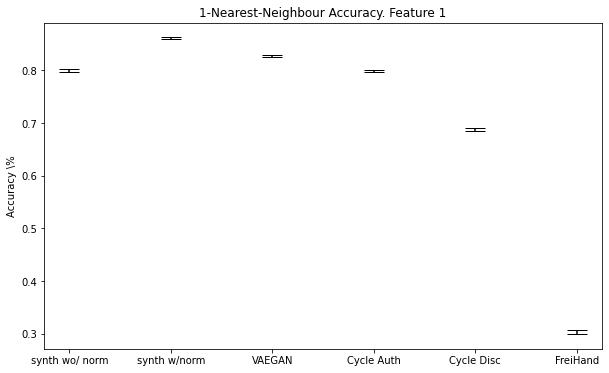

In [203]:
value = 23 # change value for different metric according to key dictionary
means, stds = [],[]
for v in scores:
    try:
        means.append(scores[v][0][value])
        stds.append(scores[v][1][value])
    except:
        pass
n = 6
plt.figure(figsize=(10,6))
plt.title(keys[value])
plt.errorbar(np.arange(n), means[:n], stds[:n], fmt='ok', capsize=10, markersize=0)
plt.xticks(np.arange(6), ['synth wo/ norm', 'synth w/norm', 'VAEGAN', 'Cycle Auth', 'Cycle Disc', 'FreiHand'])
plt.ylabel('Score')